In [52]:
__author__ = 'Eva Agrawal & Robin de Groot'

In [53]:
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn

# Deep Learning for NLP - lab exercise 1

In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence. The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!

We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:
* turorials: http://pytorch.org/tutorials/
* documentation: http://pytorch.org/docs/master/ 

**Hard deadline**: December 3, 2019


## Report

On top of this notebook, you must submit a report explaining your neural network, it's training method and report+analyse results, for example with different hyper-parameters (number of hidden layers, different embedding size, different hidden representation size, w or w/o dropout...you choose what you want to explore!).
You can also report results with different training dataset sizes (how does the number of training instances impact dev/test results? => *WARNING* obviously, here you change the training set size but you freeze the dev/test sets).

Training with the full dataset may be slow depending on your computer.

## Data

The data can be download here: http://teaching.caio-corro.fr/2019-2020/OPT7/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [54]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [55]:
LIM=5000
txtfile = "./Data/imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = "./Data/imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  ./Data/imdb.pos  /  1  lines discarded
Load  5000  lines from  ./Data/imdb.neg  /  1  lines discarded


In [56]:
postxt

[['do', "n't", 'miss', 'it', 'if', 'you', 'can'],
 ['dreams', 'of', 'a', 'young', 'girl'],
 ['funny', 'funny', 'movie', '!'],
 ['pride', 'and', 'prejudice', 'is', 'absolutely', 'amazing', '!', '!'],
 ['quirky', 'and', 'effective'],
 ['mike', 'leigh', "'s", 'best', 'and', 'the', 'best', 'of', '2010'],
 ['an', 'experience', 'unmatched', 'in', 'film'],
 ['if',
  'john',
  'woo',
  'were',
  'to',
  'of',
  'filmed',
  'the',
  'wizard',
  'of',
  'oz',
  'on',
  'the',
  'set',
  'of',
  'the',
  'wild',
  'bunch'],
 ['it',
  'has',
  'its',
  'shortcomings',
  ',',
  'and',
  'i',
  'presume',
  'the',
  'book',
  'would',
  'be',
  'much',
  'better',
  'but',
  'it',
  'is',
  'still',
  'well',
  'worth',
  'watching'],
 ['csi', 'meets', 'the', 'x', 'files'],
 ['get', 'in', 'the', 'back', 'of', 'the', 'van', '!'],
 ['a', 'great', 'companion', 'to', 'the', 'movie', '!'],
 ['excellent', 'film'],
 ['were', 'the', 'israilis', 'who', 'caused', 'real', 'terror', '\\?'],
 ['headline', 'pixar

Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [57]:
# A label of 1 means that the review is positive, 0 means negative

label_pos = [1. for i in range(len(postxt))]
label_neg = [0. for i in range(len(negtxt))]

In [58]:
trainset = postxt + negtxt
labels = label_pos + label_neg

test_size = 0.2
dev_size = 0.2

X_traindev, X_test, y_traindev, y_test = train_test_split(trainset,
                                                         labels,
                                                         test_size=test_size,
                                                         random_state=42,
                                                         stratify=labels)

X_train, X_dev, y_train, y_dev = train_test_split(X_traindev,
                                                  y_traindev,
                                                  test_size=dev_size/(1-test_size),
                                                  random_state=42,
                                                  stratify=y_traindev)    

In [59]:
X_train

[['far', 'and', 'away', ',', 'the', 'best', 'of', 'the', 'draculas', '!'],
 ['hg', 'wells', 'in', 'name', 'alone'],
 ['horrible'],
 ['what', 'the', 'hell', '!', '!', '!'],
 ['not',
  'quite',
  'a',
  'classic',
  ',',
  'but',
  'worth',
  'the',
  'watch',
  'all',
  'the',
  'same'],
 ['avatar', 'pocahontas', 'in', 'space'],
 ['blah', 'fest', '2003'],
 ['worst', 'cooper', 'movie', 'ever'],
 ['boring', ',', 'inaccurate', ',', 'uninspired'],
 ['a', 'great', 'hammer', 'film', 'even', 'without', 'christopher', 'lee'],
 ['not', 'many', 'films', 'fail', 'as', 'this', 'one', 'does'],
 ['for', 'the', 'older', 'viewers'],
 ['very', 'porlly', 'conceived', 'and', 'executed'],
 ['one', 'of', 'the', 'worst', 'musicals', 'ever', 'made'],
 ['pretentious', 'and', 'unintelligent', 'handling', 'of', 'the', 'subject'],
 ['the', 'abc', "'", 'dossier', "'"],
 ['the',
  'one',
  'that',
  'started',
  'it',
  'all',
  '\\(',
  'and',
  'then',
  'some',
  '\\)'],
 ['disgusting', 'sick', 'monster'],
 ['as

In [50]:
y_train

[1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0

# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [34]:
vocab_size = 0
dictionary = {}
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        if X_train[i][j] not in dictionary:
            dictionary[X_train[i][j]] = vocab_size
            vocab_size += 1

In [35]:
def transform_to_tensor(data, dictionary):
    Tnsr = []        
    for item in data:
        if item in dictionary.keys():
            Tnsr.append(dictionary[item]) 
    return th.tensor(Tnsr)

In [60]:
X_train

[['far', 'and', 'away', ',', 'the', 'best', 'of', 'the', 'draculas', '!'],
 ['hg', 'wells', 'in', 'name', 'alone'],
 ['horrible'],
 ['what', 'the', 'hell', '!', '!', '!'],
 ['not',
  'quite',
  'a',
  'classic',
  ',',
  'but',
  'worth',
  'the',
  'watch',
  'all',
  'the',
  'same'],
 ['avatar', 'pocahontas', 'in', 'space'],
 ['blah', 'fest', '2003'],
 ['worst', 'cooper', 'movie', 'ever'],
 ['boring', ',', 'inaccurate', ',', 'uninspired'],
 ['a', 'great', 'hammer', 'film', 'even', 'without', 'christopher', 'lee'],
 ['not', 'many', 'films', 'fail', 'as', 'this', 'one', 'does'],
 ['for', 'the', 'older', 'viewers'],
 ['very', 'porlly', 'conceived', 'and', 'executed'],
 ['one', 'of', 'the', 'worst', 'musicals', 'ever', 'made'],
 ['pretentious', 'and', 'unintelligent', 'handling', 'of', 'the', 'subject'],
 ['the', 'abc', "'", 'dossier', "'"],
 ['the',
  'one',
  'that',
  'started',
  'it',
  'all',
  '\\(',
  'and',
  'then',
  'some',
  '\\)'],
 ['disgusting', 'sick', 'monster'],
 ['as

In [61]:
y_train

[1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0

# Neural network definition

The neural network should be defined as follows:
- it takes as input a tensor that is a sequence of integers indexing word embeddings
- it retrieves the word embeddings from an embedding table
- it constructs the "input" of the MLP by summing over all embeddings (i.e. bag-of-word model)
- it build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- it project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

In [36]:
class CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 1)
        
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        out = self.embeddings(inputs).sum(0)
        out = self.linear1(out)
        return out

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [37]:
BCELogitLoss = th.nn.BCEWithLogitsLoss()

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [38]:
def accuracy(model, 
             X, 
             y, 
             dictionary):
    correct = 0
    total = 0
    for data, label in zip(X, y):
        x = transform_to_tensor(data, dictionary)
        if x.size()[0] <= 0:
            continue
        output = model(x)
        total += 1
        if (output >= 0) == (label == 1.):
            correct += 1
    return correct/total * 100

def train(model, 
          optimizer, 
          loss_function, 
          X, 
          y, 
          X_val, 
          y_val, 
          dictionary):
    cost = 0
    data, label = shuffle(X, y)
    for examp, target in zip(data, label):
        model.zero_grad()
        output = model(transform_to_tensor(examp, dictionary))
        loss = loss_function(output, th.tensor([target]))
        loss.backward()
        optimizer.step()
        cost += loss.item()
    mean_loss = cost / len(y)
    acc = accuracy(model, X_val, y_val, dictionary)
    return mean_loss, acc, model

def training_loop(model, 
                  optimizer, 
                  loss_function, 
                  n_epochs, 
                  X, 
                  y, 
                  X_val, 
                  y_val, 
                  dictionary):
    loss_list = []
    dev_acc_list = []
    for epoch in range(n_epochs):
        print("Starting epoch: {}".format(epoch))
        mean_loss, accuracy, model = train(model, optimizer, loss_function, X, y, X_val, y_val, dictionary)
        
        loss_list.append(mean_loss)
        dev_acc_list.append(accuracy)  

        print('mean loss : ', mean_loss)
        print('accuracy on dev set : ', accuracy)
    return model, loss_list, dev_acc_list

In [39]:
def plot_graphs(mean_losss, 
                dev_accus, 
                embedding_size, 
                n_hidden_layers):
    plt.plot([i for i in range(EPOCHS)],mean_losss, label='mean loss')
    plt.plot([i for i in range(EPOCHS)],dev_accus, label='accuracy on dev')
    plt.xlabel('Epochs')
    plt.title('{} hidden layers, {} embedding_size'.format(n_hidden_layers,
                                                          embedding_size))
    plt.legend()
    plt.savefig('{}HiddenLayer{}.png'.format(n_hidden_layers,
                                            embedding_size))
    plt.show()

Starting epoch: 0
4126.394666640554
mean loss :  0.6877324444400923
accuracy on dev set :  66.96969696969697
Starting epoch: 1
3298.6986327571212
mean loss :  0.5497831054595202
accuracy on dev set :  71.96969696969697
Starting epoch: 2
2735.3643318724016
mean loss :  0.45589405531206695
accuracy on dev set :  74.69696969696969
Starting epoch: 3
2357.7423099403995
mean loss :  0.3929570516567333
accuracy on dev set :  75.65656565656566
Starting epoch: 4
2086.709636745002
mean loss :  0.3477849394575004
accuracy on dev set :  75.55555555555556
Starting epoch: 5
1867.7096548004934
mean loss :  0.31128494246674887
accuracy on dev set :  76.66666666666667
Starting epoch: 6
1691.3647958149368
mean loss :  0.2818941326358228
accuracy on dev set :  76.76767676767676
Starting epoch: 7
1550.2243314122609
mean loss :  0.25837072190204347
accuracy on dev set :  76.81818181818181
Starting epoch: 8
1417.7049765318534
mean loss :  0.2362841627553089
accuracy on dev set :  76.86868686868686
Starting 

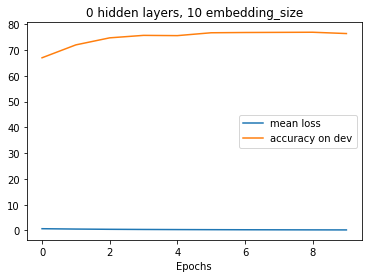

Starting epoch: 0
3733.4815666951836
mean loss :  0.6222469277825305
accuracy on dev set :  73.33333333333333
Starting epoch: 1
2682.459622861299
mean loss :  0.4470766038102165
accuracy on dev set :  75.85858585858585
Starting epoch: 2
2145.3046365093483
mean loss :  0.35755077275155805
accuracy on dev set :  77.12121212121212
Starting epoch: 3
1739.8195393800383
mean loss :  0.28996992323000637
accuracy on dev set :  77.47474747474747
Starting epoch: 4
1481.7749230249967
mean loss :  0.2469624871708328
accuracy on dev set :  77.27272727272727
Starting epoch: 5
1280.4353632696752
mean loss :  0.2134058938782792
accuracy on dev set :  77.47474747474747
Starting epoch: 6
1137.7752269640164
mean loss :  0.18962920449400272
accuracy on dev set :  76.91919191919192
Starting epoch: 7
994.5754308980441
mean loss :  0.1657625718163407
accuracy on dev set :  77.32323232323233
Starting epoch: 8
924.2875126032836
mean loss :  0.15404791876721394
accuracy on dev set :  78.28282828282829
Starting 

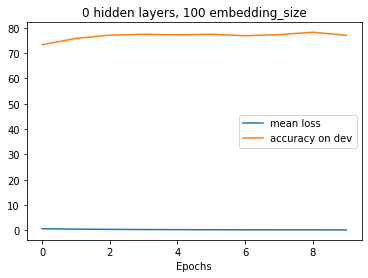

Starting epoch: 0
5663.171147112389
mean loss :  0.9438618578520649
accuracy on dev set :  70.85858585858585
Starting epoch: 1
3964.3504560584915
mean loss :  0.6607250760097486
accuracy on dev set :  76.26262626262627
Starting epoch: 2
3358.8972377465197
mean loss :  0.5598162062910866
accuracy on dev set :  75.20202020202021
Starting epoch: 3
2941.5257016825376
mean loss :  0.4902542836137563
accuracy on dev set :  75.45454545454545
Starting epoch: 4
2514.8470772098344
mean loss :  0.41914117953497243
accuracy on dev set :  75.9090909090909
Starting epoch: 5
2326.994681783633
mean loss :  0.3878324469639388
accuracy on dev set :  75.15151515151514
Starting epoch: 6
2101.332313576612
mean loss :  0.35022205226276865
accuracy on dev set :  75.60606060606061
Starting epoch: 7
2124.415278898928
mean loss :  0.35406921314982137
accuracy on dev set :  77.17171717171716
Starting epoch: 8
1850.835494155323
mean loss :  0.3084725823592205
accuracy on dev set :  74.5959595959596
Starting epoch

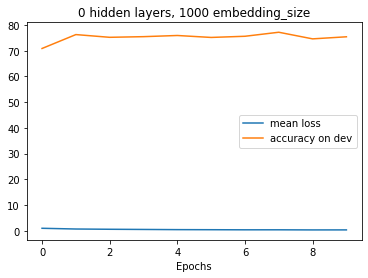

In [40]:
embedding_sizes = [10, 100, 1000]
models_list = []
mean_loss_list = []
dev_accuracy_list = []

EPOCHS = 10
n_hidden_layers = 0

for embedding_size in embedding_sizes:
    model = CBOW_classifier(vocab_size, embedding_size)
    optimizer = th.optim.Adam(model.parameters(),lr=0.001)
    model, mean_losses, dev_accus = training_loop(model, optimizer, BCELogitLoss, EPOCHS, X_train, y_train, X_dev, y_dev, dictionary)
    models_list.append(model)
    mean_loss_list.append(mean_losses)
    dev_accuracy_list.append(dev_accus)
    plot_graphs(mean_losses, dev_accus, embedding_size, n_hidden_layers)

## Layer testing

Now that we have found a value for the embedding size that balances training time and performance (embedding_size = 10), we go on to test different numbers of hidden layers. We test adding one layer and adding two layers. More testing with more layers and a different number of nodes per hidden layer would of course be ideal, but due to time and computational limitations, only these tests are run

In [41]:
class CBOW_classifier1layer(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier1layer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, int(embedding_dim/2))
        self.activation_function1 = nn.ReLU()
        self.linear2 = nn.Linear(int(embedding_dim/2), 1)
        
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        out = self.embeddings(inputs).sum(0)
        out = self.linear1(out)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out

Starting epoch: 0
4018.4825140200555
mean loss :  0.6697470856700093
accuracy on dev set :  64.84848484848484
Starting epoch: 1
3338.557565538329
mean loss :  0.5564262609230548
accuracy on dev set :  71.46464646464646
Starting epoch: 2
2825.375454652567
mean loss :  0.47089590910876117
accuracy on dev set :  74.4949494949495
Starting epoch: 3
2468.0542198765115
mean loss :  0.4113423699794186
accuracy on dev set :  75.80808080808082
Starting epoch: 4
2185.6694032043365
mean loss :  0.36427823386738944
accuracy on dev set :  76.51515151515152
Starting epoch: 5
1957.2923272778542
mean loss :  0.3262153878796424
accuracy on dev set :  76.96969696969697
Starting epoch: 6
1777.843683663773
mean loss :  0.29630728061062883
accuracy on dev set :  77.27272727272727
Starting epoch: 7
1611.8319120607125
mean loss :  0.2686386520101188
accuracy on dev set :  76.86868686868686
Starting epoch: 8
1468.4977983272884
mean loss :  0.24474963305454805
accuracy on dev set :  77.22222222222223
Starting e

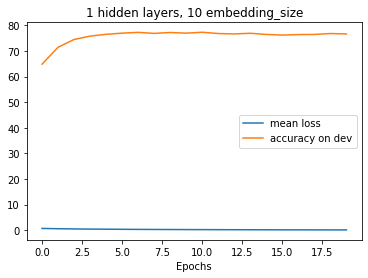

In [42]:
embedding_size = 10
models_list_layertest = []
mean_loss_list_layertest = []
dev_accuracy_list_layertest = []

EPOCHS = 20
n_hidden_layers = 1

model = CBOW_classifier1layer(vocab_size, embedding_size)
optimizer = th.optim.Adam(model.parameters(),lr=0.001)
model, mean_losses, dev_accus = training_loop(model, optimizer, BCELogitLoss, EPOCHS, X_train, y_train, X_dev, y_dev, dictionary)
models_list_layertest.append(model)
mean_loss_list_layertest.append(mean_losses)
dev_accuracy_list_layertest.append(dev_accus)
plot_graphs(mean_losses, dev_accus, embedding_size, n_hidden_layers)

In [43]:
class CBOW_classifier2layer(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier2layer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, int(embedding_dim*0.75))
        self.activation_function1 = nn.ReLU()
        self.linear2 = nn.Linear(int(embedding_dim*0.75), int(embedding_dim*0.25))
        self.activation_function2 = nn.ReLU()
        self.linear3 = nn.Linear(int(embedding_dim*0.25), 1)
        
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        out = self.embeddings(inputs).sum(0)
        out = self.linear1(out)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        out = self.linear3(out)
        return out

Starting epoch: 0
3988.4564028736204
mean loss :  0.6647427338122701
accuracy on dev set :  64.54545454545455
Starting epoch: 1
3467.912702296322
mean loss :  0.5779854503827203
accuracy on dev set :  70.70707070707071
Starting epoch: 2
3029.718971130413
mean loss :  0.5049531618550689
accuracy on dev set :  73.28282828282828
Starting epoch: 3
2694.7165749393653
mean loss :  0.4491194291565609
accuracy on dev set :  75.70707070707071
Starting epoch: 4
2437.1395303757663
mean loss :  0.40618992172929436
accuracy on dev set :  75.70707070707071
Starting epoch: 5
2237.812006538446
mean loss :  0.3729686677564077
accuracy on dev set :  76.11111111111111
Starting epoch: 6
2060.76358515483
mean loss :  0.343460597525805
accuracy on dev set :  77.12121212121212
Starting epoch: 7
1905.2873161105006
mean loss :  0.31754788601841677
accuracy on dev set :  77.07070707070707
Starting epoch: 8
1779.2711326581007
mean loss :  0.2965451887763501
accuracy on dev set :  76.91919191919192
Starting epoch

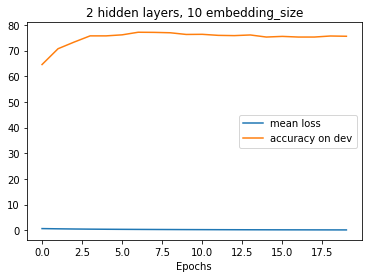

In [44]:
embedding_sizes = 10

EPOCHS = 20
n_hidden_layers = 2

model = CBOW_classifier2layer(vocab_size, embedding_size)
optimizer = th.optim.Adam(model.parameters(),lr=0.001)
model, mean_losses, dev_accus = training_loop(model, optimizer, BCELogitLoss, EPOCHS, X_train, y_train, X_dev, y_dev, dictionary)
models_list_layertest.append(model)
mean_loss_list_layertest.append(mean_losses)
dev_accuracy_list_layertest.append(dev_accus)
plot_graphs(mean_losses, dev_accus, embedding_size, n_hidden_layers)

## Dropout testing

Now that we have found a good number of layers (1) for the network, we can go on and test some dropout values.

In [45]:
class CBOW_classifier1layerdropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout_value):
        super(CBOW_classifier1layerdropout, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, int(embedding_dim/2))
        self.activation_function1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_value)
        self.linear2 = nn.Linear(int(embedding_dim/2), 1)
        
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        out = self.embeddings(inputs).sum(0)
        out = self.linear1(out)
        out = self.activation_function1(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return out

Starting epoch: 0
4024.328783592209
mean loss :  0.6707214639320349
accuracy on dev set :  63.63636363636363
Starting epoch: 1
3634.2632720863758
mean loss :  0.6057105453477293
accuracy on dev set :  68.63636363636364
Starting epoch: 2
3198.9042275107195
mean loss :  0.5331507045851199
accuracy on dev set :  71.81818181818181
Starting epoch: 3
2827.339122281607
mean loss :  0.4712231870469345
accuracy on dev set :  74.34343434343434
Starting epoch: 4
2585.6267792453637
mean loss :  0.4309377965408939
accuracy on dev set :  74.34343434343434
Starting epoch: 5
2288.8590151942785
mean loss :  0.38147650253237975
accuracy on dev set :  74.19191919191918
Starting epoch: 6
2091.4357699673465
mean loss :  0.3485726283278911
accuracy on dev set :  76.41414141414141
Starting epoch: 7
1944.596676773445
mean loss :  0.3240994461289075
accuracy on dev set :  75.9090909090909
Starting epoch: 8
1797.3321257233272
mean loss :  0.2995553542872212
accuracy on dev set :  75.30303030303031
Starting epoc

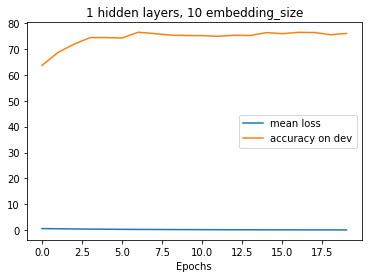

Starting epoch: 0
4232.081122746691
mean loss :  0.7053468537911152
accuracy on dev set :  56.313131313131315
Starting epoch: 1
3978.39705388085
mean loss :  0.6630661756468083
accuracy on dev set :  64.44444444444444
Starting epoch: 2
3661.408454137156
mean loss :  0.6102347423561927
accuracy on dev set :  69.8989898989899
Starting epoch: 3
3363.1439519073
mean loss :  0.56052399198455
accuracy on dev set :  71.86868686868686
Starting epoch: 4
3091.1309422516115
mean loss :  0.5151884903752686
accuracy on dev set :  72.87878787878788
Starting epoch: 5
2880.938715285844
mean loss :  0.48015645254764067
accuracy on dev set :  73.7878787878788
Starting epoch: 6
2677.683069524372
mean loss :  0.44628051158739535
accuracy on dev set :  74.54545454545455
Starting epoch: 7
2523.753088571949
mean loss :  0.4206255147619915
accuracy on dev set :  75.1010101010101
Starting epoch: 8
2434.314171387552
mean loss :  0.405719028564592
accuracy on dev set :  75.1010101010101
Starting epoch: 9
2291.39

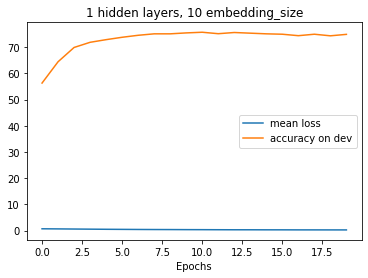

Starting epoch: 0
4244.3934097914025
mean loss :  0.7073989016319004
accuracy on dev set :  55.959595959595966
Starting epoch: 1
4014.929395388812
mean loss :  0.6691548992314686
accuracy on dev set :  59.1919191919192
Starting epoch: 2
3811.5614155083313
mean loss :  0.6352602359180552
accuracy on dev set :  62.22222222222222
Starting epoch: 3
3584.9780285471525
mean loss :  0.5974963380911921
accuracy on dev set :  63.93939393939394
Starting epoch: 4
3384.917747116604
mean loss :  0.5641529578527673
accuracy on dev set :  63.030303030303024
Starting epoch: 5
3342.3801736674986
mean loss :  0.5570633622779164
accuracy on dev set :  65.7070707070707
Starting epoch: 6
3161.761451151823
mean loss :  0.5269602418586372
accuracy on dev set :  64.94949494949495
Starting epoch: 7
3050.456775854654
mean loss :  0.5084094626424424
accuracy on dev set :  66.46464646464646
Starting epoch: 8
3000.3351198022137
mean loss :  0.500055853300369
accuracy on dev set :  66.41414141414141
Starting epoch:

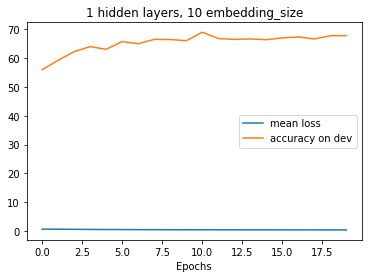

In [46]:
embedding_sizes = 10
models_list_dropout = []
mean_loss_list_dropout = []
dev_accuracy_list_dropout = []
dropout_list = [0.2, 0.5, 0.7]

EPOCHS = 20
n_hidden_layers = 1

for dropout_value in dropout_list:
    model = CBOW_classifier1layerdropout(vocab_size, embedding_size, dropout_value)
    optimizer = th.optim.Adam(model.parameters(),lr=0.001)
    model, mean_losses, dev_accus = training_loop(model, optimizer, BCELogitLoss, EPOCHS, X_train, y_train, X_dev, y_dev, dictionary)
    models_list.append(model)
    mean_loss_list.append(mean_losses)
    dev_accuracy_list.append(dev_accus)
    plot_graphs(mean_losses, dev_accus, embedding_size, n_hidden_layers)